# Gravity

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from geoana import gravity
from scipy.constants import G

G_mgal_cc = G * 1E8

Today's goals:
* Densities and Density Contrasts
* More on Time-varying effects
* Survey Design

## Density
* Recall: Density is the amount of mass per unit volume

### Densities of common materials
![densities](https://gpg.geosci.xyz/_images/gravity_table.gif)

* Average continental crustal densities
    * Mostly felsic 
    * Composition approximately:
        * Feldspar ~41%
        * Quartz ~ 12%
        * Pyroxenes ~ 11%
    * Near surface ~2.66 g/cc
    * Deep crust ~3.1 g/cc

*Q*: Which element is the most common by weight%?

* Oceanic crust?
    * Mafic

* Continental crust is on average less dense than oceanic crust
* Continents float on ocean crust (Subduction zones!)


### What's in my data?
To understand and interpret gravity data in exploration geophysics, we must first understand everything that is contributing to our measurements.  Specifically, the relevant questions one might ask include:
* When I put my gravity-meter on the ground, what are the total sources contributing to the measured data?
* Which components of my data are static, and which are time-varying?
* What components of the data do I want to keep, and what do I want to remove?

When I put my gravity-meter on the ground, what are the total sources contributing to the measured data?

For most cases in exploration geophysics, your gravity data are responding to the following combination of sources:

1) First-order approximation: field due to a sphere (spherical earth): $g_z = \gamma \frac{M}{R^2}$
1) Vertical gradient: distance from the center of the earth
1) Latitude variation: flattened rotating sphere
1) Geoid: internal density variations
1) Isostatic compensation:  variations in crustal thickness
1) Tidal effect: gravity fields due to the sun and moon
1) Other time-varying effects: (Atmospheric pressure, temperature, etc.)
1) Variations due to local geology


$$ g_{total} = g_{sphere} + g_{free-air} + g_{latitude} + g_{geoid} + g_{iso} + g_{drift} + g_{local}$$

The combined field variations (1-7)defines the “normal” field to be expected even in the absence of geological variations.

$$g_{background} = g_{sphere} + g_{free-air} + g_{latitude} + g_{geoid} + g_{iso} + g_{drift}$$

Further deviation from this “normal” field is our anomalous field, which constitutes the data of interest for most exploration cases, we want $g_{local}$.

$$g_{local} = g_{total} - g_{background} $$

**Gravity Anomaly**:
$$\Delta g = g_{total} - g_{background} $$

* The part of field that makes the measured gravity data different from the background field.
* This is the part produced by local geology--the interesting part in exploration geophysics.

**note**: Most gravity measurements are done with relative gravimeters anyways, for which you don't know the static level of $g$, meaning the gravity anomaly is the only thing we can consider.

## Density Contrasts
When modeling and interpreting collected gravity data, we are interested in modeling the anomalous field.

How does that work?

Consider the gravity field due to an infinite slab of dense material with a thickness $h$ and density $\rho$:

$$ g_{slab} = 2\pi \gamma \rho h $$

In [42]:
x = np.linspace(-100, 100, 256)
rho_slab = 2.15
h_slab = 2000

![back](resources/background.png)

Text(0, 0.5, 'Gz (mGal)')

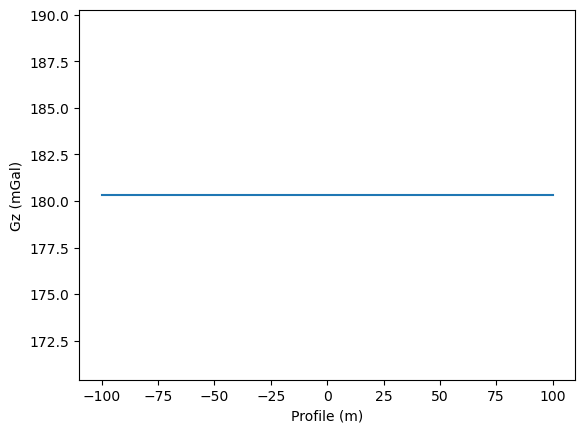

In [48]:
gz_slab = 2 * np.pi * G_mgal_cc * rho_slab * h_slab * np.ones_like(x)
plt.plot(x, gz_slab)
plt.xlabel('Profile (m)')
plt.ylabel('Gz (mGal)')

Now what if there is something below?

![total](resources/total_model.png)

In [53]:
rho_sphere = 3.2
sphere = gravity.Sphere(radius=20, rho = rho_sphere - rho_slab, location=[0, 0, 25])
gz_sphere = sphere.gravitational_field(
    np.c_[x, np.zeros_like(x), np.zeros_like(x)]
)[:, -1] * 1E8  # Factor to get units right for mgal / cc
g_total = gz_sphere + gz_slab

Text(0, 0.5, 'Gz (mGal)')

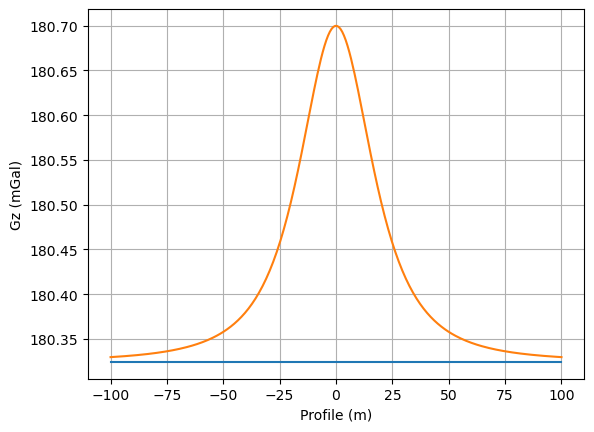

In [66]:
plt.plot(x, gz_slab)
plt.plot(x, g_total)
plt.grid()
plt.xlabel('Profile (m)')
plt.ylabel('Gz (mGal)')

What is the anomalous field?

Text(0, 0.5, 'Gz anomalous (mGal)')

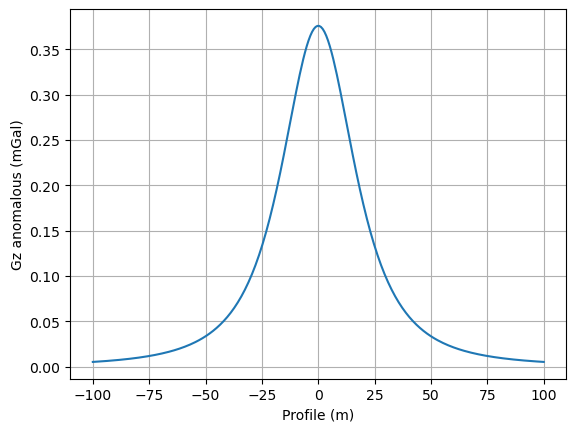

In [67]:
g_anom = g_total - gz_slab
plt.plot(x, g_anom)
plt.grid()
plt.xlabel('Profile (m)')
plt.ylabel('Gz anomalous (mGal)')

What if it was measured with a relative gravimeter, and the we set everything to be relative to the center point?

In [76]:
def make_plot(rel_index):
    plt.plot(x, g_anom, label='anomalous')
    plt.plot(x, g_total - g_total[rel_index], label='relative')
    plt.grid()
    plt.legend()
    plt.scatter(x[rel_index], 0, marker='x', color='C1')
    plt.xlabel('Profile (m)')
    plt.ylabel(r'$\Delta$Gz anomalous (mGal)')

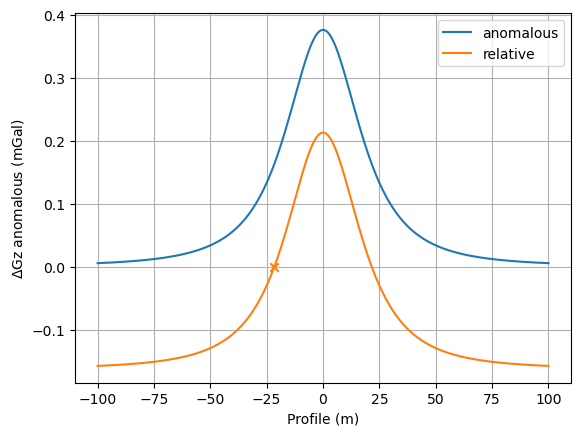

In [80]:
make_plot(100)

So what do we use when modeling?
![model](resources/relative.png)

## Corrections

* When you collect gravity, before you can interpret that data, you need to perform certain correction (reductions) to eliminate components that you aren’t interested in

* Therefore, you first need to understand what is contributing to your total data, and how to remove the unwanted contributions

* Think back to all of those contributions we talked about.

### Tidal effects
* both the sun and moon exert gravitational force
* varies with the time because of the location of the sun and moon

![SunMoon](resources/tidal_example.png)

If Earth was rigid and all we were concerned about was the sun and moon's positions:
$$\Delta g_z = \frac{3\gamma R M_{moon}}{2 D_{moon}^3}(\cos(2 a_{moon}) + \frac{1}{3}) + \frac{3\gamma R M_{sun}}{2 D_{sun}^3}(\cos(2 a_{sun}) + \frac{1}{3})$$

* But it's not...
    * The water mass deforms
    * The earth itself deforms
* Effect magnified by about 1.16

### Other time varying effects:
* Atmospheric pressure
* Temperature
* Any else?

## Drift Corrections

### At a single location:
Observed tidal effect
* This temporal component is not related to geology and must be removed from the observation.
* Large scale or stationary survey can be corrected by this analytic formula.
* Smaller scale survey is often corrected together with instrument drift by using repeated measurements at a single station.

![gravity variations](resources/tidal_change.png)

* Base station is essential for most surveys
* It can be located off of your survey line/grid and simply used for corrections
* Often, the base station is a part of your survey line/grid, and it would be the first point
* Time to return to base station: varies…let’s discuss

![corr](resources/drift_correction.png)

Correction method:
* approximate the drift curve by line segments
* remove the difference between the value
     * of a given point on drift curve and the 
     * value of the first point.

* calculate by linear interpolation: if the
     * time of a station reading falls between
     * i’th and (i+1)’th base-station reading,

Linear Interpolation:
$$ f_{interp}(x) = \frac{f_2 - f_1}{x_2 - x_1}(x - x_1) + f_1 $$

Evaluate at the appropriate time, and subtract it!

## Survey Design
So all together when designing gravity surveys we must consider:
* How fast does the field change?
* Where should I place a base station?
* How often should I repeat at a base station?
* What order should I visit my stations?
* Do I need multiple base stations?

### Station Spacing
The sharpness of gravity anomalies you see are related to the depth of the density anomalies
* At a *minimum* you can observe the anomaly with a station spacing equal to the target depth.

In [90]:
def plot_samp(nx):
    
    x_loc1 = np.linspace(-100, 100, nx)
    print(x_loc1[1] - x_loc1[0])
    g_samp = sphere.gravitational_field(
        np.c_[x_loc1, np.zeros_like(x_loc1), np.zeros_like(x_loc1)]
    )[:, -1] * 1E8

    plt.plot(x, g_anom)
    plt.scatter(x_loc1, g_samp)

25.0


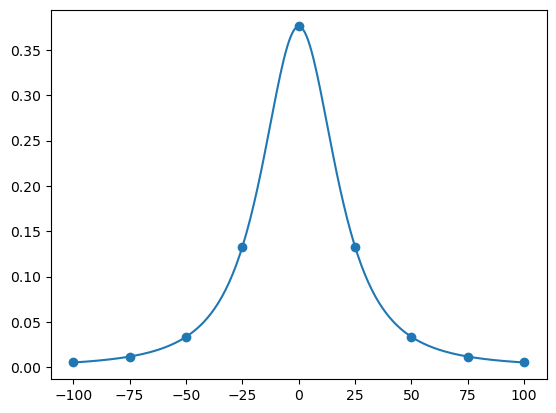

In [94]:
plot_samp(9)

Why might you want to sample more often?
* But there might be more items in your survey area than you would expect, so sampling more often is recommended

### Reference point
* Ideally, you're reference point is uneffected by your density anomaly
    * Pick somewhere reasonably away.
* But, you don't know what else could effect your reference point. 

### Looping
Fundamentally, gravity surveys are carried out in loops.
* You always loop back to the base station.

Consider these stations, and let's come up with a few valid ways to visit each of these stations:

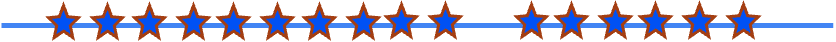

# Lab on Thursday

We are going underground beneath MINES Thursday! You will measure the depth and geometry of the two tunnels that we seek to detect with Gravity the week after that. You will model the gravity anomaly of the two tunnels after the tour in order to predict the anomaly and plan your surveys.  The tunnel will be tight and warm.

* Meet: GC-B52 (Brian’s office), by 1pm.  Please do not be late!!!!!
* You have to protect your body:
    * hard hats
    * closed toe shoes
    * pants
    * long sleeves
* If you do not bring your own hard hat, we will provide it for you.

Afterwards, make sure you have your laptop, as we will be modelling gravity!